# Task 11
## Subtask 1: Bifurcation map using cupy arrays

* Let $x_n \in [0,1]$ - the ratio of the population value in the $n^{th}$ year to the maximum possible value. $x_{n-1} \in [0,1]$ - the same, but in the previous year.
* Let $r>0$ - the rate of reproduction (growth) of the population.
Then population size at discrete times (seasons):

$$
x_n = rx_{n-1}(1-x_{n-1}), r \in [0,4], x_0 \in \mathbb{R} - random \in {[0,1]}
$$

Let define multidimentional case:

$$X_n = R * X_{n-1} (E - X_{n-1})$$

Or in details (Adamar's product):
$$
\begin{equation*}
\begin{bmatrix}
x^{11}_n & \dots & x^{1N}_n \\
\dots & \dots & \dots \\
x^{M1}_n & \dots & x^{MN}_n
\end{bmatrix}
=
\begin{bmatrix}
r^{11} & \dots & r^{1N}\\
\dots & \dots & \dots \\
r^{M1} & \dots & r^{MN}
\end{bmatrix}
\circ
\begin{bmatrix}
x^{11}_{n-1} & \dots & x^{1N}_{n-1} \\
\dots & \dots & \dots \\
x^{M1}_{n-1} & \dots & x^{MN}_{n-1}
\end{bmatrix}
\circ
\Bigg (
\begin{bmatrix}
1^{11} & \dots & 1^{1N}\\
\dots & \dots & \dots \\
1^{M1} & \dots & 1^{MN}
\end{bmatrix}
-
\begin{bmatrix}
x^{11}_{n-1} & \dots & x^{1N}_{n-1} \\
\dots & \dots & \dots \\
x^{M1}_{n-1} & \dots & x^{MN}_{n-1}
\end{bmatrix}
\Bigg)
\end{equation*}
$$

$$
\begin{equation*}
x^{1j}_{0} \dots x^{Mj}_{0} = [1, \dots ,0] (line space), j \in [1,N] \\
r^{i1}_{0} \dots x^{iN}_{0} = [0, \dots ,4] (line space), i \in [1,M]
\end{equation*}
$$

Here we calculate evolution for each $r$ value with every possible init condition $x_0 \in [0,1]$ or random init condition.

Populating the interactive namespace from numpy and matplotlib


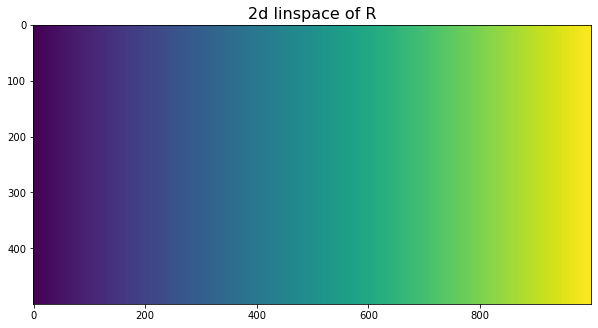

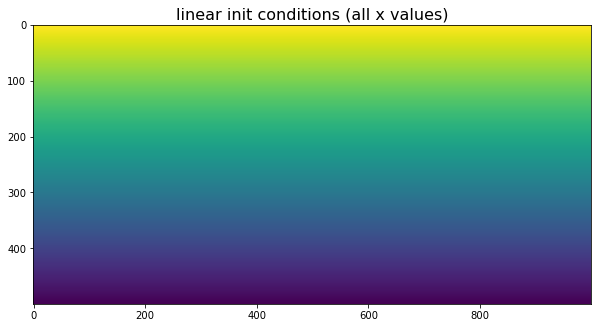

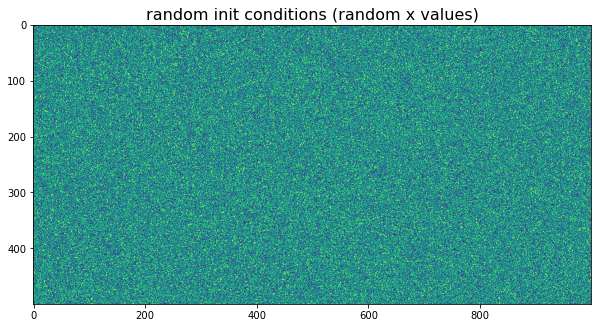

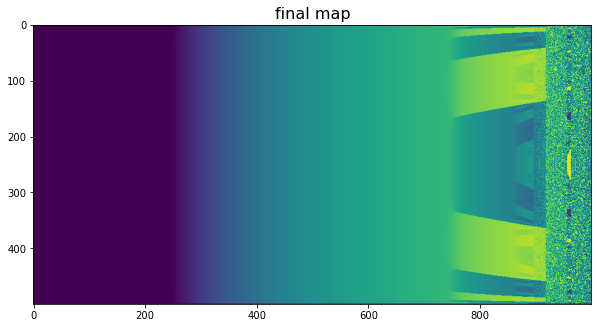

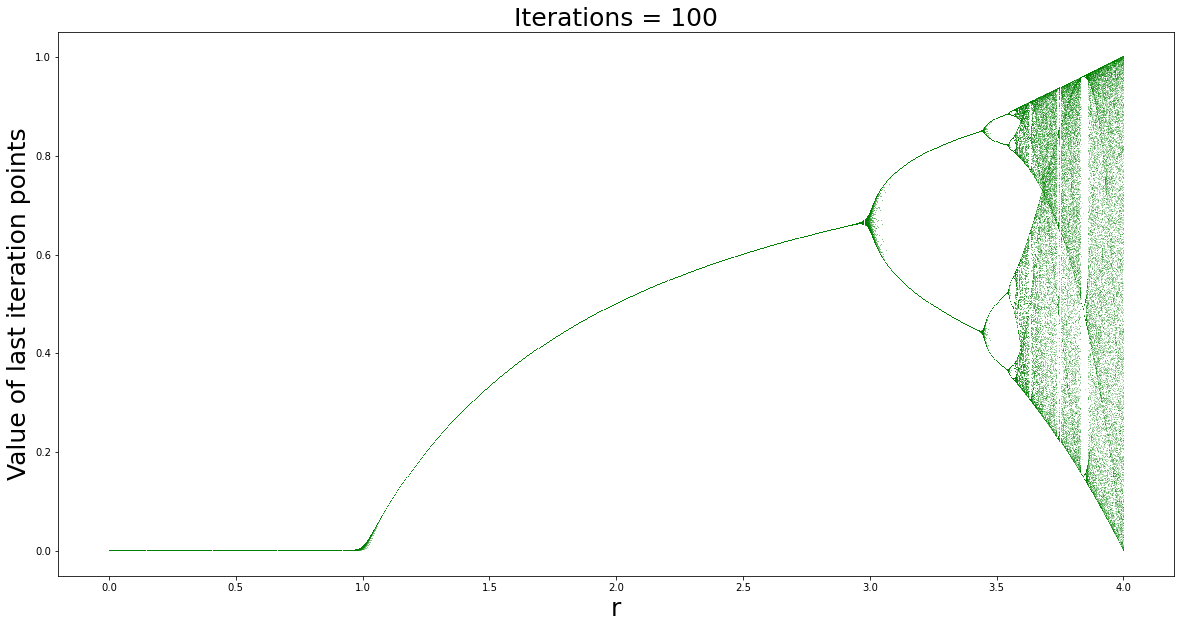

In [1]:
%pylab inline

import cupy as cp
# import numpy as np
# import matplotlib.pyplot as plt
from numba import cuda

def CuPu_bifurcation(points_r = 1000, points_y = 1000, start_r = 0, end_r = 4, maxiter = 1000, plot = True):
    
    # creating 2d linspace of R:
    multiplier = cp.ones([points_y,1])
    linspaceR_1d = cp.linspace(start_r, end_r, points_r).reshape([1,points_r])
    linspaceR_2d = multiplier @ linspaceR_1d
    
    plt.figure(figsize=(10, 10))
    plt.title('2d linspace of R', fontsize=16)
    plt.imshow(linspaceR_2d.get())
    plt.show()
    
    # init conditions (all values of x or random)
    init_conditions1 = cp.random.rand(linspaceR_2d.shape[0], linspaceR_2d.shape[1])
    init_conditions =  cp.linspace(1, 0, points_y).reshape([points_y,1]) @ cp.ones([1,points_r])
    
    plt.figure(figsize=(10, 10))
    plt.title('linear init conditions (all x values)', fontsize=16)
    plt.imshow(init_conditions.get())
    plt.show()
    plt.figure(figsize=(10, 10))
    plt.title('random init conditions (random x values)', fontsize=16)  
    plt.imshow(init_conditions1.get())
    plt.show()
    
    # recursive algorithm
    init = init_conditions
    
    for i in range(maxiter):
        init = init * linspaceR_2d * (1 - init)
    
    plt.figure(figsize=(10, 10))
    plt.title('final map', fontsize=16) 
    plt.imshow(init.get())
    plt.show()
    
    if plot == True:
        fig = plt.figure(figsize=(20, 10))
        for j in range (1):
            plt.plot(linspaceR_2d[1:499,0:].get(), init[1:499,0:].get(),',',color ='g',alpha=.28)
        plt.title("Iterations = " + str(maxiter), fontsize=25)
        plt.xlabel("r", fontsize=25)
        plt.ylabel("Value of last iteration points", fontsize=25)
        plt.close()
        return fig
    else:
        return None
    
CuPu_bifurcation(points_r = 1000, points_y = 500, start_r = 0, end_r = 4, maxiter = 100, plot = True)

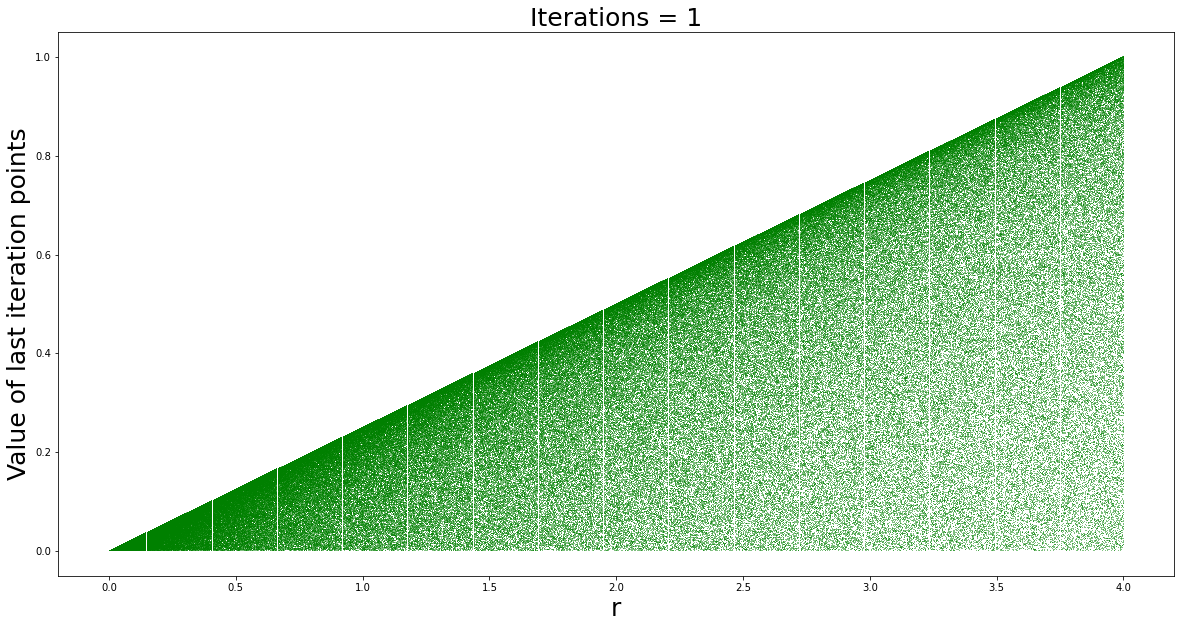

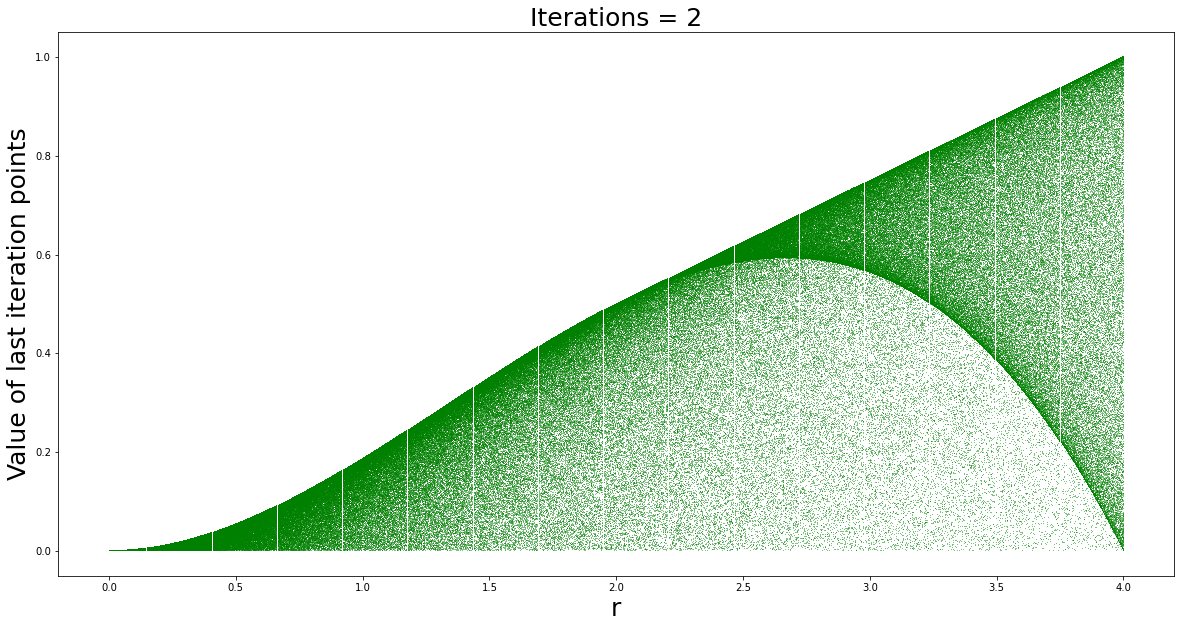

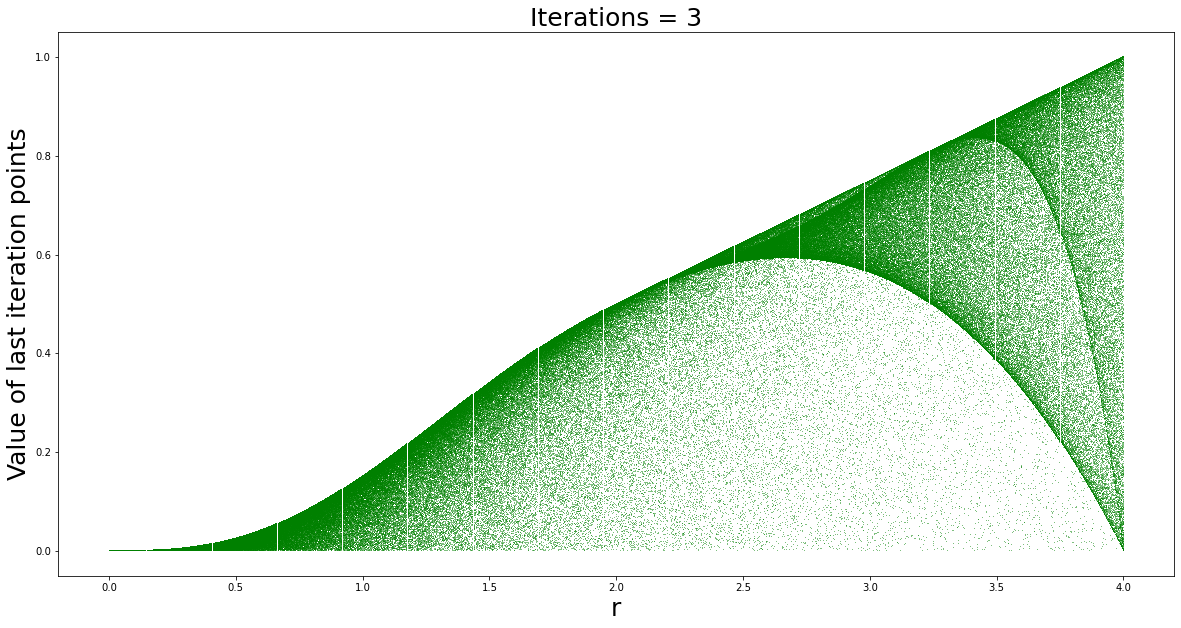

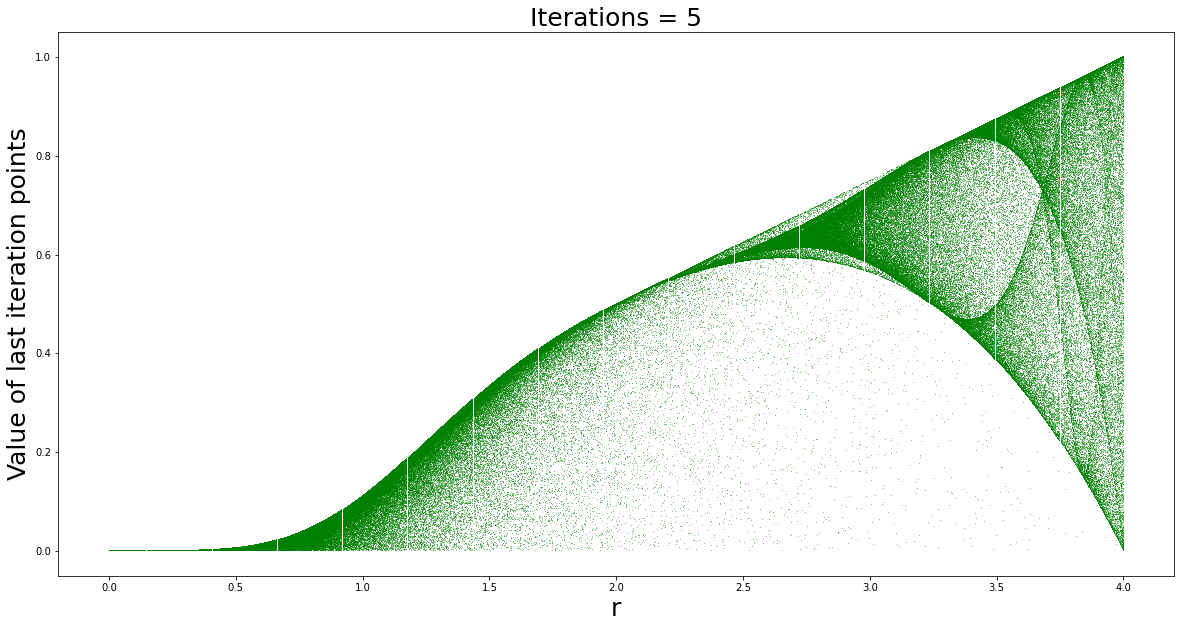

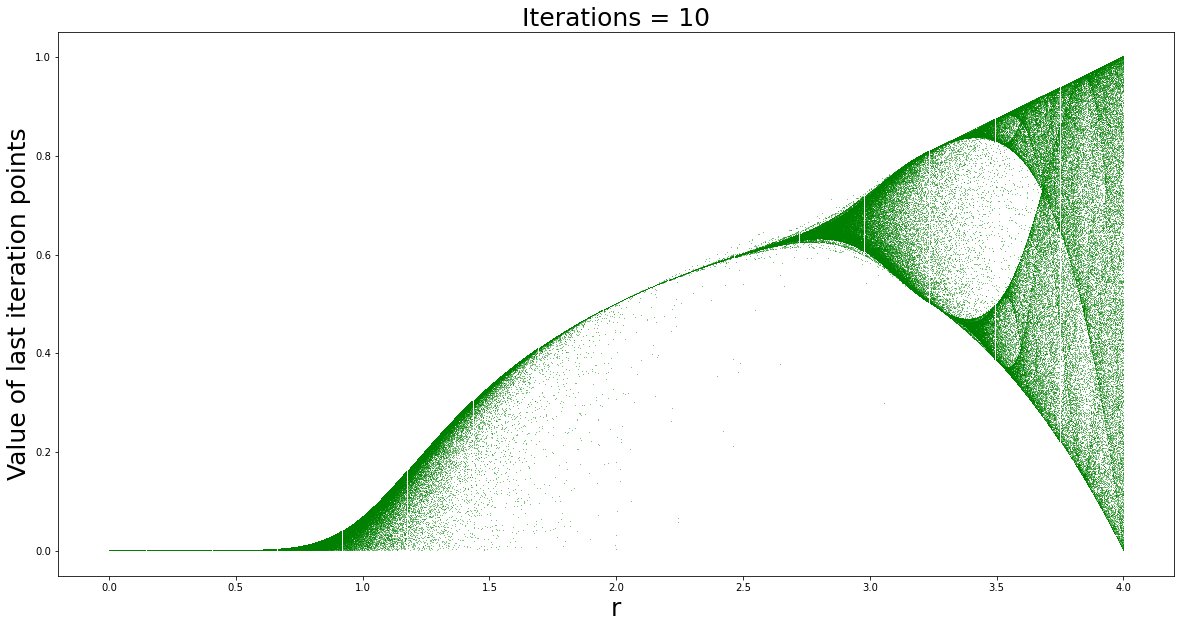

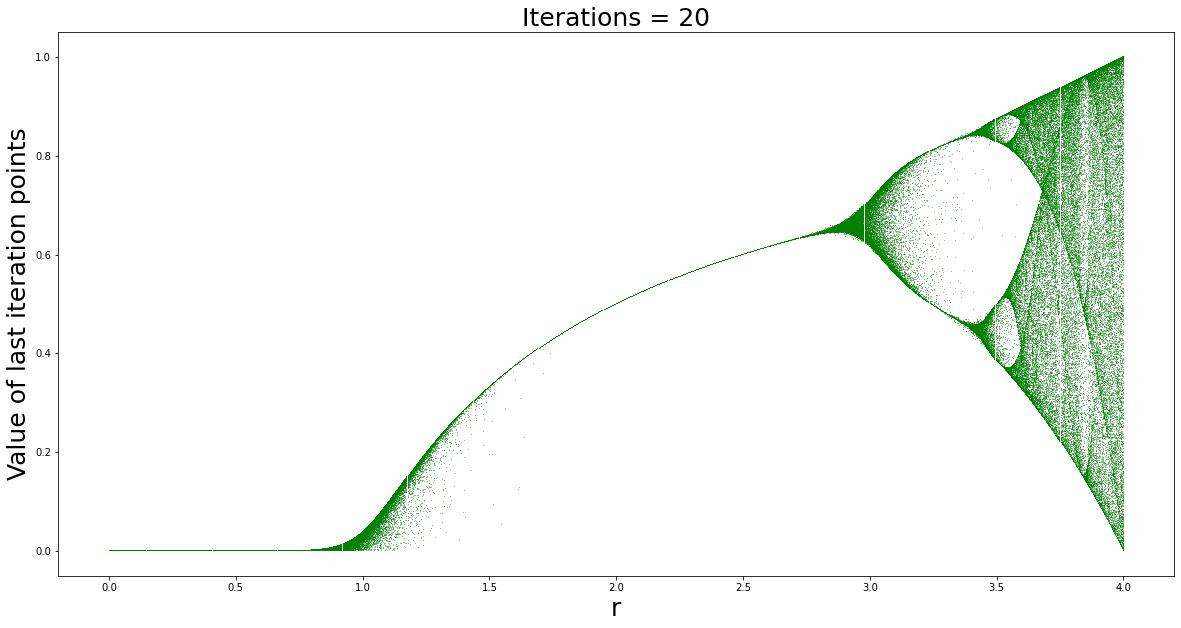

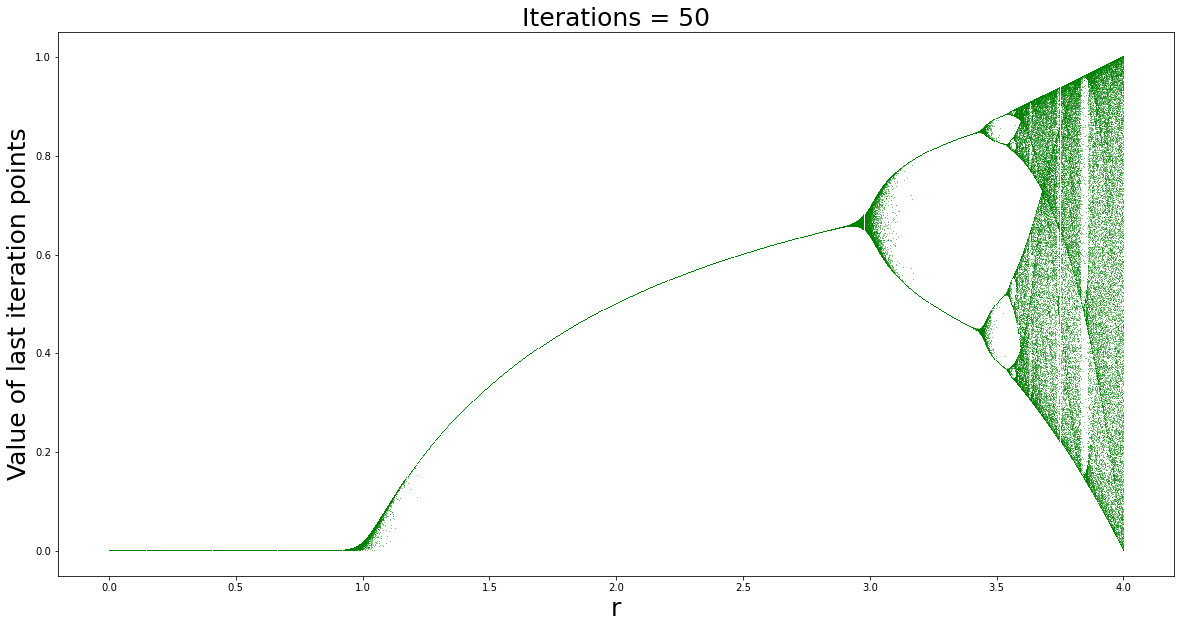

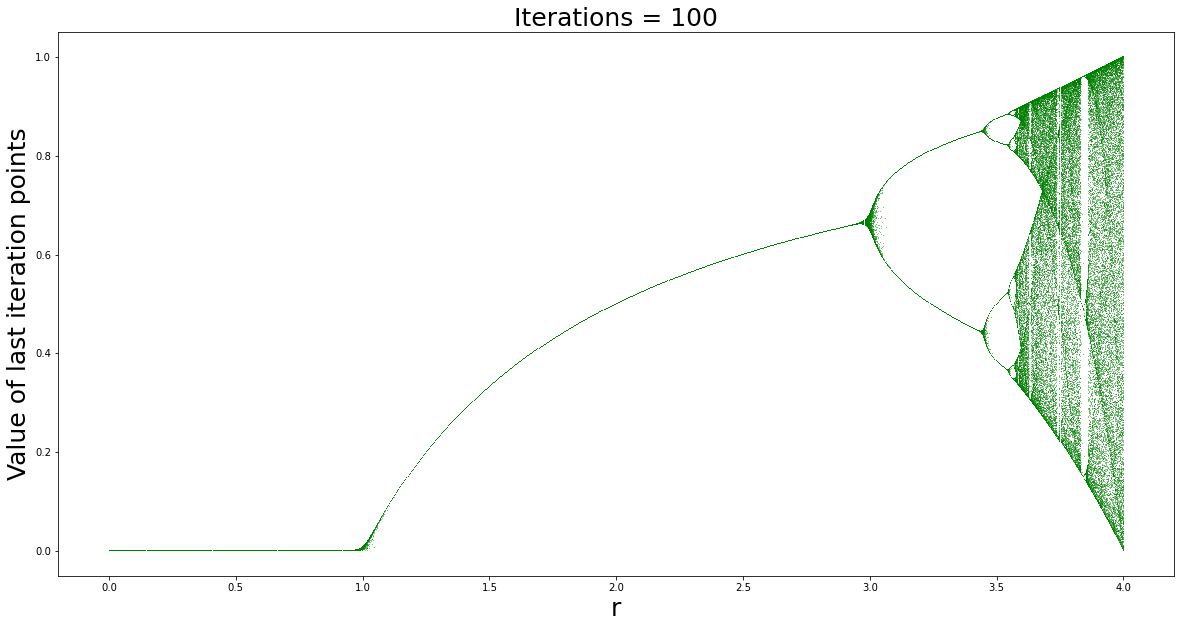

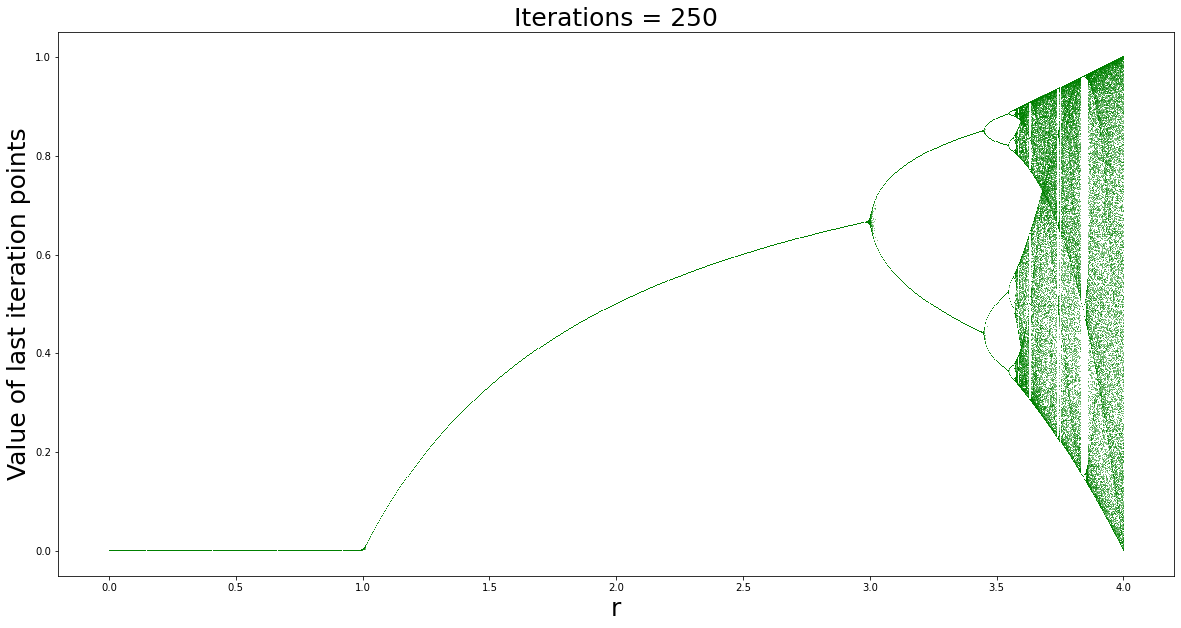

In [2]:
def CuPu_bifurcation(points_r = 1000, points_y = 1000, start_r = 0, end_r = 4, maxiter = 1000, plot = True):

    # creating 2d linspace of R:
    multiplier = cp.ones([points_y,1])
    linspaceR_1d = cp.linspace(start_r, end_r, points_r).reshape([1,points_r])
    linspaceR_2d = multiplier @ linspaceR_1d
    
    # init conditions (all values of x or absolutely random)
    init_conditions = cp.random.rand(linspaceR_2d.shape[0], linspaceR_2d.shape[1])
#     init_conditions =  cp.linspace(1, 0, points_y).reshape([points_y,1]) @ cp.ones([1,points_r])
    
    # recursive algorithm
    init = init_conditions
    for i in range(maxiter):
            init = init * linspaceR_2d * (1 - init)
    
    if plot == True:
        fig = plt.figure(figsize=(20, 10))
        for j in range (1):
            plt.plot(linspaceR_2d[1:499,0:].get(), init[1:499,0:].get(),',',color ='g',alpha=.5)
        plt.title("Iterations = " + str(maxiter), fontsize=25)
        plt.xlabel("r", fontsize=25)
        plt.ylabel("Value of last iteration points", fontsize=25)
#         plt.close()
        return fig
    else:
        return None
    
for iters in [1,2,3,5,10,20,50,100,250]:
    CuPu_bifurcation(points_r = 1000, points_y = 1000, start_r = 0, end_r = 4, maxiter = iters, plot = True)

## Subtask 2: Bifurcation map using cupy arrays is profiled

In [3]:
%load_ext snakeviz
%snakeviz CuPu_bifurcation(points_r = 1000, points_y = 1000, start_r = 0, end_r = 4, maxiter = 300, plot = False)

 
*** Profile stats marshalled to file '/tmp/tmp3tnln2_5'. 
Embedding SnakeViz in this document...


In [4]:
%prun -r CuPu_bifurcation(points_r = 1000, points_y = 1000, start_r = 0, end_r = 4, maxiter = 300, plot = False)

         931 function calls in 0.012 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.011    0.011    0.012    0.012 <ipython-input-2-ff4b2323d150>:1(CuPu_bifurcation)
      301    0.001    0.000    0.001    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
        1    0.000    0.000    0.000    0.000 {method 'fill' of 'cupy.core.core.ndarray' objects}
      300    0.000    0.000    0.001    0.000 <__array_function__ internals>:2(min_scalar_type)
        1    0.000    0.000    0.000    0.000 ranges.py:61(_linspace_scalar)
        1    0.000    0.000    0.000    0.000 basic.py:134(ones)
        1    0.000    0.000    0.012    0.012 {built-in method builtins.exec}
      300    0.000    0.000    0.000    0.000 multiarray.py:583(min_scalar_type)
        1    0.000    0.000    0.000    0.000 _generator.py:608(random_sample)
        2    0.000    0.000    0.000    0.000 basic.py:7(empty)

## Subtask 3: Graph - computation time vs number of total iterations (CPU, MPI, CuPy implementations)

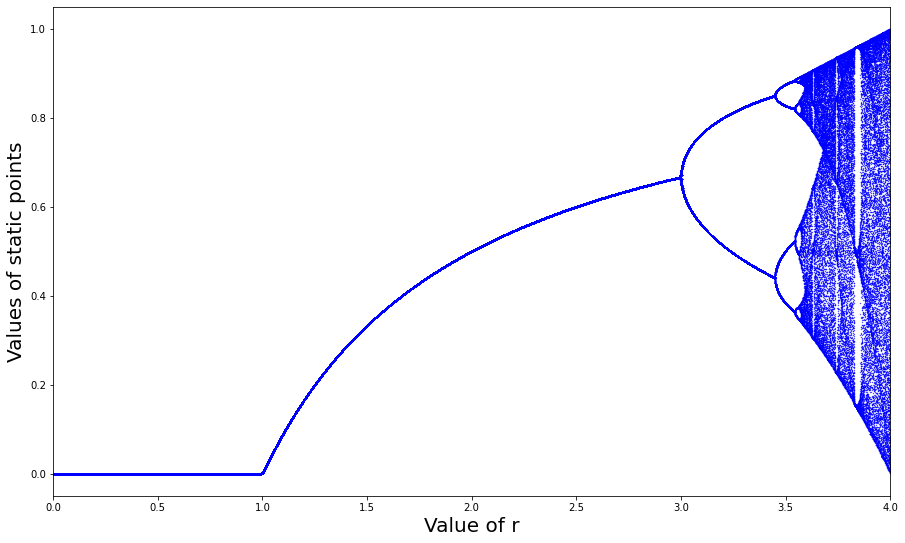

In [5]:
def func(pointsX = 1000, minX = 0, maxX = 4, m = 10, steps = 100):
    r = np.linspace(minX, maxX, pointsX) # the range of r

    X = np.zeros((pointsX, m)) # array for scatterplot
    Y = np.zeros((pointsX, m)) # array for scatterplot
    x = np.zeros(steps)
    
    for j in arange(pointsX):
        x[0] = np.random.rand() # random initial value
        for n in range(1,steps):
            # choose 1 option
            x[n] = r[j] * x[n-1] * (1 - x[n-1])
            # x[n] = r[j] * sin(x[n-1])
            
        X[j] = (x[steps-m:steps]) # take into account the last m values
        Y[j] = r[j] # set r value for each x[inf] - for scatter plot

    return X, Y

def plotBifurcationMap(pointsX = 10000, minX = 0, maxX = 4, m = 40, steps = 500, plot = True):
    X, Y = func(pointsX = 10000, minX = 0, maxX = 4, m = 40, steps = 500)
    if plot == True:
        fig = plt.figure(figsize=(15, 9))
        xlim((minX, maxX))   # set the xlim to left, right
        #ylim(0, 1)     # set the xlim to left, right
        plt.ylabel('Values of static points', fontsize=20)
        plt.xlabel('Value of r', fontsize=20)
        plt.scatter(Y,X, c = 'b', s = 0.1)
        plt.close()
        return fig
    else:
        return None

plotBifurcationMap(pointsX = 10000, minX = 0, maxX = 4, m = 40, steps = 500, plot = True)

In [7]:
%%writefile bifurcation.py

import matplotlib.pyplot as plt

from mpi4py import MPI
import math
import numpy as np
import argparse

parser = argparse.ArgumentParser('gameoflife')
parser.add_argument('-f', type = int, default = 0, help='frame')
flag = parser.parse_args()
flag = flag.f

def count(proc, points_X = 1000, n_proc = 10, minX = 0, maxX = 4, steps = 1000, m = 30):
    block_X = int(points_X / n_proc) # integer blocks of x axis
    remainder = points_X % n_proc # remainder for the last block

    add = 0 # addition of the last block
    if proc == n_proc-1: # if current process is last
        add = remainder # addition is equal to remainder
    
    # current x array (last with add =/= 0)
    arrayX = np.arange(block_X * proc, block_X * (proc+1) + add, 1)
    
    r = np.linspace((proc) * maxX / n_proc, (proc + 1) * maxX / n_proc, arrayX.size)
    # print(arrayX.size)
    
    X = np.zeros((block_X, m)) # array for scatterplot
    Y = np.zeros((block_X, m)) # array for scatterplot
    x = np.zeros(steps)
    
    for j in range(0, block_X, 1):
        x[0] = np.random.rand()
        
        for n in range(1,steps):
            x[n] = r[j] * x[n-1] * (1 - x[n-1])
            
        X[j] = (x[steps-m:steps]) # take into account the last m values
        Y[j] = r[j] # set r value for each x[inf] - for scatter plot
    return X, Y

comm = MPI.COMM_WORLD
n_proc = comm.Get_size() # processors
rank = comm.Get_rank() # current rank

if rank == 0:
    print('nprocs = ', n_proc)
    t0 = MPI.Wtime() # measure start time
  

X,Y = count(proc = rank, points_X = 10000, n_proc = n_proc, minX = 0, maxX = 4, steps = flag, m = 20)

X, Y = comm.gather(X, root=0), comm.gather(Y, root=0)

if rank == 0:
    fig = plt.scatter(Y,X, c = 'b', s = 0.1)
    totalTime = MPI.Wtime() - t0
    print('',np.round((totalTime),4) * 1000, 'mSec')

Overwriting bifurcation.py


### Run CuPy

In [9]:
CuPy = []
for i in range(30, 300, 20):
    t = %timeit -o -q CuPu_bifurcation(points_r = 10000, points_y = 500, start_r = 0, end_r = 4, maxiter = i, plot = False)
    CuPy.append(t)

### Run CPU

In [10]:
CPU = []
for i in range(30, 300, 20):
    t = %timeit -o -q plotBifurcationMap(pointsX = 10000, minX = 0, maxX = 4, m = 40, steps = i, plot = False)
    CPU.append(t)

### Run MPI

In [11]:
import subprocess

MPI = []
for i in range(30, 300, 20):
    a = subprocess.run(["mpirun","-n", str(4),"python", "bifurcation.py", '-f', str(i)],         
        universal_newlines=True,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE)
    res = list(a.stdout.strip().split(' '))
    MPI.append(res[4])
    
MPI = list(map(float, MPI))

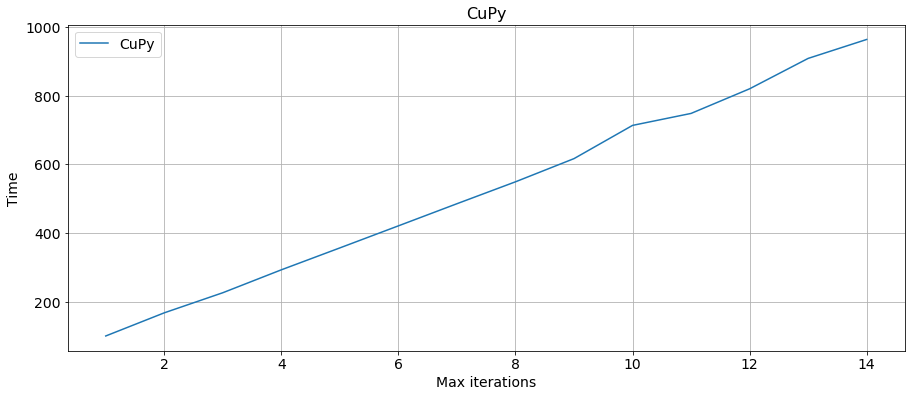

In [12]:
plt.figure(figsize=(15,6))
plt.plot(np.arange(1, len(CuPy)+1, 1), [1000 * i.average for i in CuPy])
#plt.plot(np.arange(1, len(CPU)+1, 1), [i.average for i in CPU])
#plt.plot(np.arange(1, len(MPI)+1, 1), MPI)

plt.title('CuPy', fontsize=16)
#plt.yscale('log')
plt.xlabel('Max iterations', fontsize=14)
plt.ylabel('Time', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['CuPy'], fontsize=14);
plt.grid()
plt.show()

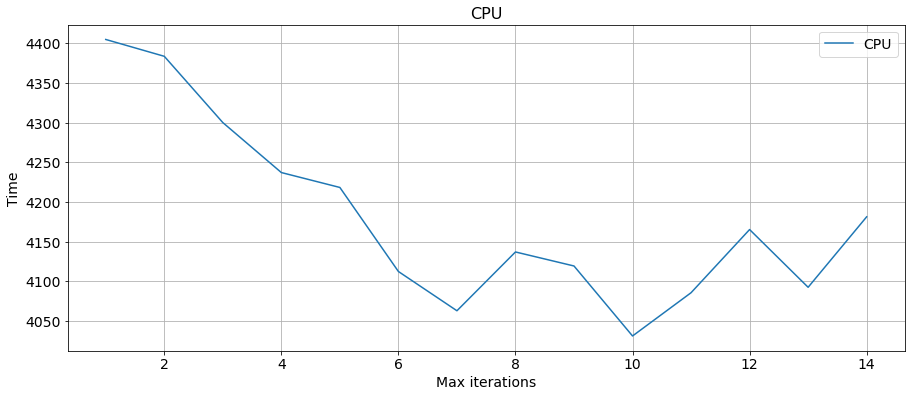

In [13]:
plt.figure(figsize=(15,6))
#plt.plot(np.arange(1, len(CuPy)+1, 1), [i.average for i in CuPy])
plt.plot(np.arange(1, len(CPU)+1, 1), [1000 * i.average for i in CPU])
#plt.plot(np.arange(1, len(MPI)+1, 1), MPI)

plt.title('CPU', fontsize=16)
#plt.yscale('log')
plt.xlabel('Max iterations', fontsize=14)
plt.ylabel('Time', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['CPU'], fontsize=14);
plt.grid()
plt.show()

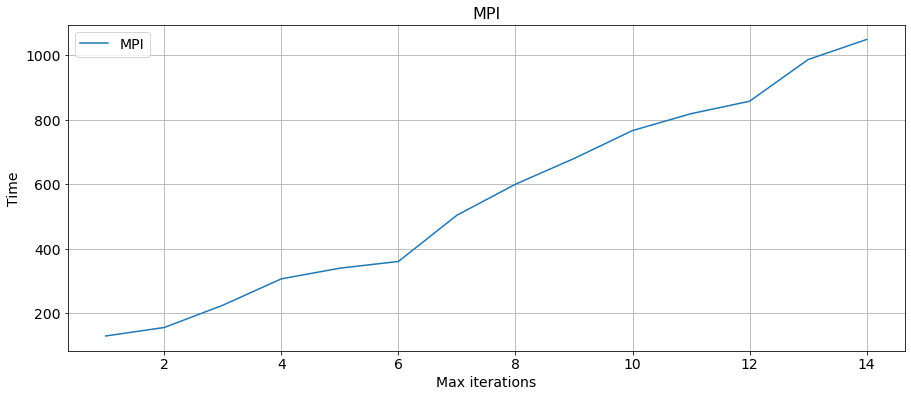

In [14]:
plt.figure(figsize=(15,6))
#plt.plot(np.arange(1, len(CuPy)+1, 1), [i.average for i in CuPy])
#plt.plot(np.arange(1, len(CPU)+1, 1), [i.average for i in CPU])
plt.plot(np.arange(1, len(MPI)+1, 1), MPI)

plt.title('MPI', fontsize=16)
#plt.yscale('log')
plt.xlabel('Max iterations', fontsize=14)
plt.ylabel('Time', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['MPI'], fontsize=14);
plt.grid()
plt.show()

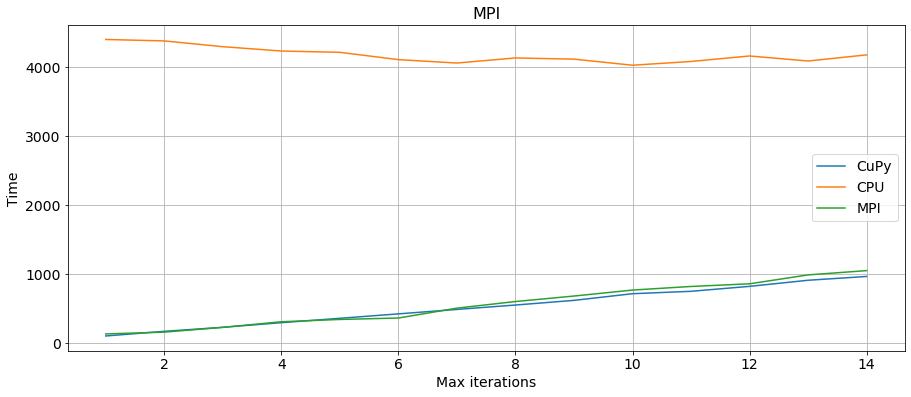

In [15]:
plt.figure(figsize=(15,6))
plt.plot(np.arange(1, len(CuPy)+1, 1), [1000*i.average for i in CuPy])
plt.plot(np.arange(1, len(CPU)+1, 1), [1000*i.average for i in CPU])
plt.plot(np.arange(1, len(MPI)+1, 1), MPI)

plt.title('MPI', fontsize=16)
#plt.yscale('log')
plt.xlabel('Max iterations', fontsize=14)
plt.ylabel('Time', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['CuPy','CPU','MPI'], fontsize=14);
plt.grid()
plt.show()

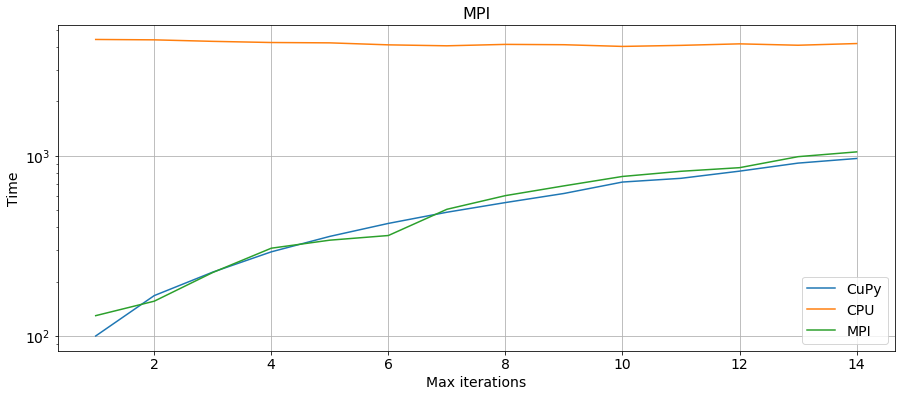

In [16]:
plt.figure(figsize=(15,6))
plt.plot(np.arange(1, len(CuPy)+1, 1), [1000*i.average for i in CuPy])
plt.plot(np.arange(1, len(CPU)+1, 1), [1000*i.average for i in CPU])
plt.plot(np.arange(1, len(MPI)+1, 1), MPI)

plt.title('MPI', fontsize=16)
plt.yscale('log')
plt.xlabel('Max iterations', fontsize=14)
plt.ylabel('Time', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['CuPy','CPU','MPI'], fontsize=14);
plt.grid()
plt.show()